# Hate Crime at the U.S. and CA level

In [13]:
# Import library and packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

## Data cleaning of FBI's 1991-2020 Hate Crime Dataset

### *U.S. level*

In [14]:
# Read in hate_crime.csv dataset
hc = pd.read_csv("./../datasets/hate_crime.csv")

# make header names lowercase so easier to work with
hc.columns = [col.lower() for col in hc.columns]

# Rename data_year col to "year"
hc.rename(columns = {"data_year":"year"}, inplace = True)

# Remove rows with missing values about offender's race
hc = hc.dropna(subset = ["offender_race"])

# Remove unnecessary columns
hc = hc.drop(["ori", "pub_agency_unit"], axis = 1)

# Fix nebraska abbreviation
hc = hc.replace("NB", "NE")

# Create bias categories: race/ethnicity (race/ethn), "sex", "lgbt", "religion", "disability", "other"
bias_cat_dic = {"race/ethn": ['Anti-Black or African American', 'Anti-White','Anti-Arab',
                              'Anti-Asian', 'Anti-Hispanic or Latino','Anti-Other Race/Ethnicity/Ancestry',
                              'Anti-Multiple Races, Group', 'Anti-American Indian or Alaska Native',
                              'Anti-Native Hawaiian or Other Pacific Islander',
                              'Anti-Eastern Orthodox (Russian, Greek, Other)'],
               "sex": ['Anti-Female', 'Anti-Male'],
               "lgbt": ['Anti-Gay (Male)','Anti-Heterosexual','Anti-Lesbian (Female)',
                        'Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)','Anti-Bisexual',
                       'Anti-Gender Non-Conforming','Anti-Transgender',],
               "religion":['Anti-Jewish','Anti-Protestant','Anti-Other Religion','Anti-Islamic (Muslim)',
                          'Anti-Catholic','Anti-Multiple Religions, Group','Anti-Atheism/Agnosticism', 
                           "Anti-Jehovah's Witness",'Anti-Mormon','Anti-Buddhist','Anti-Sikh',
                           'Anti-Other Christian','Anti-Hindu',],
               "disability":['Anti-Physical Disability','Anti-Mental Disability'],
               "other":["Unknown (offender's motivation not known)"]}

# ID what bias category each hate crime incidence is and add to dataframe
bias_cat = []
for bias in hc["bias_desc"]:
    if ";" not in bias:
        for key in bias_cat_dic:
            bias_lst = bias_cat_dic[key]
            if bias in bias_lst:
                bias_cat.append(key)
                break
    elif ";" in bias:
        # for incidents with more than one biases (these bias_cat begins with "mix")
        sub_biases = bias.split(";")
        temp_cat = "mix"
        for sub_bias in sub_biases:
            for key in bias_cat_dic:
                bias_lst = bias_cat_dic[key]
                if sub_bias in bias_lst:
                    temp_cat = temp_cat + "," + key
                    break
        bias_cat.append(temp_cat)
        
# Add bias category to dataframe
hc["bias_cat"] = bias_cat

# Remove columns with more than one bias
hc = hc[~hc["bias_cat"].str.contains("mix")]

C:\Users\tammi\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### *CA level*

#### Data cleaning 2020_CA_city_to_county.csv dataset

In [15]:
# Import county to city key
CA_c2c = pd.read_csv("../datasets/2020_CA_city_to_county.csv")

# Label which county is urban, suburban, rural
county_cat_dic = {"urban":["Alameda", "Contra Costa", "Fresno", "Los Angeles", "Orange", "Riverside", "Sacramento",
                           "San Bernardino", "San Diego", "San Francisco", "San Joaquin", "San Mateo", "Santa Clara", "Ventura"],
             "suburban":["Butte", "Imperial", "Kern", "Marin", "Merced", "Monterey", "Napa", "Placer", "San Luis Obispo",
                         "Santa Barbara", "Santa Cruz", "Shasta", "Solano", "Sonoma", "Stanislaus", "Tulare", "Yolo"],
             "rural":["Alpine", "Amador", "Calaveras", "Colusa", "Del Norte", "El Dorado", "Glenn", "Humboldt",
                      "Inyo", "Kings", "Lake", "Lassen", "Madera", "Mariposa", "Mendocino", "Modoc", "Mono", "Nevada", "Plumas",
                      "San Benito", "Sierra", "Siskiyou", "Sutter", "Tehama","Trinity","Tuolumne","Yuba"]}

# Add county category to 2020_CA_city_to_county.csv 
county_cat = []
for county in CA_c2c["county"]:
    if county in county_cat_dic["urban"]:
        county_cat.append("urban")
    elif county in county_cat_dic["suburban"]:
        county_cat.append("suburban")
    elif county in county_cat_dic["rural"]:
        county_cat.append("rural")
    else:
        county_cat.append(None)

CA_c2c["county_cat"] = county_cat

#### Creating CA only hate crime dataset with county information from 2020_CA_city_to county.csv

In [97]:
# Make a dataframe with just california data
CA_hc = hc[hc["state_abbr"] == "CA"]

# Annotating whether county is urban, suburban, and rural
county_cat = []
city_names = list(CA_c2c["city"])
for city in CA_hc["pub_agency_name"]:
    city = city.strip()
    if city in city_names:
        county_cat.append(list(CA_c2c[CA_c2c["city"]==city]["county_cat"])[0])
    elif city in county_cat_dic["urban"]:
        county_cat.append("urban")
    elif city in county_cat_dic["suburban"]:
        county_cat.append("suburban")
    elif city in county_cat_dic["rural"]:
        county_cat.append("rural")
    else:
        county_cat.append(None)

# Adding county_cat as a column to CA hc dataframe
CA_hc["county_cat"] = county_cat

# Remove rows with no county annotation
CA_hc = CA_hc[~CA_hc["county_cat"].isna()]

<ipython-input-97-7aeeb464aed2>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Data Analysis and Visualization

### *U.S. level*

#### How has the number of hate crimes changed over the years?

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Number of Hate Crime Incidents'),
 Text(0.5, 1.0, 'Change in Total Number of Hate Crimes\n in the U.S. Between 1991-2020')]

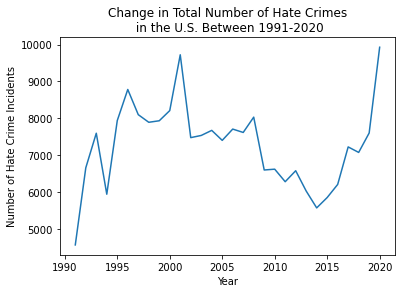

In [65]:
# Group number of hate crime incidents per year
num_hc = pd.DataFrame(hc.groupby("year")["incident_id"].count())
num_hc.reset_index(inplace = True)
num_hc.columns = ["year","num_incidents"]

# Plot reported hate crime incidents from 1991-2020
num_hc_plot = sns.lineplot(data = num_hc, x = "year", y = "num_incidents")
num_hc_plot.set(xlabel = "Year", ylabel = "Number of Hate Crime Incidents",
                title = "Change in Total Number of Hate Crimes\n in the U.S. Between 1991-2020")
#plt.savefig("US_num_hc_plot.png")

#### How do the numbers of reported hate crimes by bias category change each year?

In [18]:
# Create num bias category each year (all, including mix)
num_bias_hc = pd.DataFrame(hc.groupby(["year","bias_cat"])["incident_id"].count())
num_bias_hc.reset_index(inplace = True)
num_bias_hc.columns = ["year", "bias_cat", "num_bias_cat"]
#num_bias_hc["prop_bias"] = num_bias_hc["num_bias_cat"]/num_bias_hc.groupby("year")["num_bias_cat"].transform("sum")

In [19]:
def transpose_df(df, loop_lst, biastype, colname):
    """
    Makes bias category rows into columns to allow for stack bar charts
    df = pandas hatecrime dataframe
    biastype = bias_cat by default, and can be specified to 
    colname = column name of interest
    """
    t_dic = {}
    for bias in loop_lst:
        bias_rows = list(df[df[biastype] == bias][colname])
        while len(bias_rows) < 30:
            bias_rows = [0] + bias_rows
        t_dic[bias] = bias_rows
    t_df = pd.DataFrame(t_dic, index = range(1991,2021))
    return t_df

<Figure size 216x216 with 0 Axes>

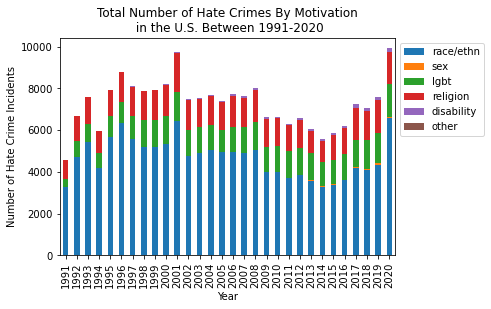

<Figure size 216x216 with 0 Axes>

In [67]:
# rearrange columns of num_bias_hc in order to make box plot
num_bias_hc_t_df = transpose_df(num_bias_hc,bias_cat_dic.keys(), "bias_cat", "num_bias_cat")

# Bar plot of number of reported hate crimes by bias category over the years
num_bias_hc_plt = num_bias_hc_t_df.plot(kind='bar', stacked=True)
num_bias_hc_plt.set(xlabel = "Year", ylabel = "Number of Hate Crime Incidents",
                title = "Total Number of Hate Crimes By Motivation\n in the U.S. Between 1991-2020")
plt.legend(bbox_to_anchor = [1, 1])
plt.figure(figsize=(3, 3))
#plt.savefig("US_num_bias_hc_plt.png")

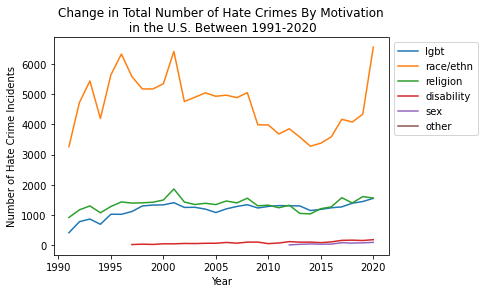

In [62]:
# Line plot of number of reported hate crimes by bias category over the years
num_bias_hc_plt = sns.lineplot(data = num_bias_hc[["year", "num_bias_cat", "bias_cat"]], x = "year",
                               y = "num_bias_cat", hue = "bias_cat")
num_bias_hc_plt.set(xlabel = "Year", ylabel = "Number of Hate Crime Incidents",
                title = "Change in Total Number of Hate Crimes By Motivation\n in the U.S. Between 1991-2020")
plt.legend(bbox_to_anchor = [1, 1])

#### Within the race/ethnicity ("race/ethn") bias category, how does racial bias change over time?

In [22]:
# num of each specific racial bias over years
racebias_hc = pd.DataFrame(hc[hc["bias_cat"] == "race/ethn"].groupby(["year", "bias_desc"])["incident_id"].count())
racebias_hc.reset_index(inplace = True)
racebias_hc.columns = ["year", "bias_desc", "num_race_incident"]
#racebias_hc["prop_bias"] = racebias_hc["num_race_incident"]/racebias_hc.groupby("year")["num_race_incident"].transform("sum")
#racebias_hc

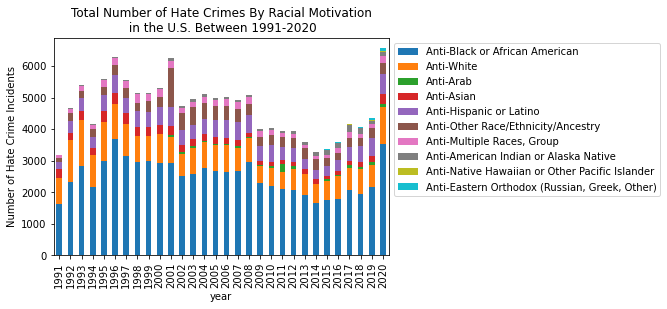

In [23]:
# rearrange columns of num_racebias_hc in order to make box plot
num_racebias_hc_t_df = transpose_df(racebias_hc, bias_cat_dic["race/ethn"], "bias_desc", "num_race_incident")

# Bar plot of number of reported hate crimes by race/ethn category over the years
num_racebias_hc_plt = num_racebias_hc_t_df.plot(kind='bar', stacked=True)
num_racebias_hc_plt.set(xlabel = "Year", ylabel = "Number of Hate Crime Incidents",
                title = "Total Number of Hate Crimes By Racial Motivation\n in the U.S. Between 1991-2020")
plt.legend(bbox_to_anchor = [1, 1])
#plt.savefig("US_num_racebias_hc_plt.png")

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Number of Hate Crime Incidents'),
 Text(0.5, 1.0, 'Change in Number of Hate Crimes By Different Racial Motivation\n in the U.S. Between 1991-2020')]

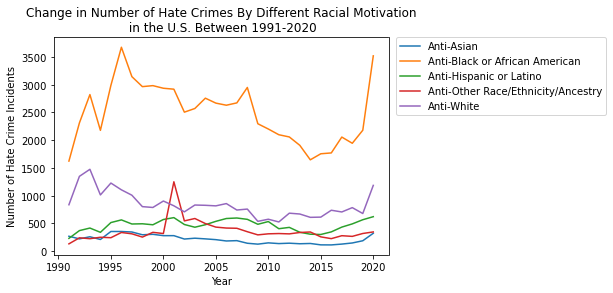

In [60]:
# Take top 5 races with most hate crime incidents to plot a line plot easier to look at
top_race = racebias_hc.groupby("bias_desc").sum().sort_values("num_race_incident", ascending = False)
top_5_race = list(top_race.iloc[0:5].index)
top_5_race_hc = racebias_hc[racebias_hc["bias_desc"].isin(top_5_race)]

# Line plot of number of reported hate crimes by race/ethn category over the years
racebias_hc_plt = sns.lineplot(data = top_5_race_hc[["year", "num_race_incident", "bias_desc"]], x = "year", y = "num_race_incident", hue = "bias_desc")
racebias_hc_plt.legend(bbox_to_anchor=(1.65, 1), loc="upper right", borderaxespad=0)
racebias_hc_plt.set(xlabel = "Year", ylabel = "Number of Hate Crime Incidents",
                title = "Change in Number of Hate Crimes By Different Racial Motivation\n in the U.S. Between 1991-2020")

#### In each state, how many hate crimes due to race/ethnicity are there in total since 1991?

In [82]:
# total incidence since 1990s of each bias category of each state
state_hc = pd.DataFrame(hc.groupby(["state_abbr", "bias_cat"])["incident_id"].count())
state_hc.reset_index(inplace = True)
state_hc.columns = ["state_name", "bias_cat", "num_bias_incident"]

In [83]:
states = [state[0] for state in hc.groupby("state_abbr")["state_abbr"]]
state_bias = []
num_incident =[]
for state in states:
    state_df = state_hc[state_hc["state_name"] == state]
    num_incident = list(state_df[state_df["bias_cat"] == "race/ethn"]["num_bias_incident"])[0]
    state_bias.append([state, num_incident])
    
race_state_bias = pd.DataFrame(state_bias, columns = ["state", "num_incident"])

In [86]:
# Map of total number of hatecrime by race/ethncity bias per state in the US since 1991
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"

racebias_map = folium.Map(location=[40, -95], zoom_start=3.5)
fig = folium.Figure(width = 800, height = 450)
fig.add_child(racebias_map)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_bias,
    columns=["state", "num_incident"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Total Number of Hate Crime Incidents since 1991",
).add_to(racebias_map)

folium.LayerControl().add_to(racebias_map)

fig.save("./figures/US_racebias.html")

racebias_map

#### In each state, how many hate crimes due to race/ethnicity are there in 2020?

In [93]:
# total number of hatecrime by race/ethncity bias per state in the US in 2020
state_hc_20 = pd.DataFrame(hc[hc["year"] == 2020].groupby(["state_abbr", "bias_cat"])["incident_id"].count())
state_hc_20.reset_index(inplace = True)
state_hc_20.columns = ["state_name", "bias_cat", "num_bias_incident"]
state_hc_20 = state_hc_20[~(state_hc_20["state_name"] == "FS")]
state_hc_20 = state_hc_20[(state_hc_20["bias_cat"] == "race/ethn")]

In [96]:
# Map of total number of hatecrime by race/ethncity bias per state in the US in 2020
racebias_20_map = folium.Map(location=[40, -95], zoom_start=3.5)
fig = folium.Figure(width = 800, height = 450)
fig.add_child(racebias_20_map)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_hc_20,
    columns=["state_name", "num_bias_incident"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Hate Crime Incidents in 2020",
).add_to(racebias_20_map)

folium.LayerControl().add_to(racebias_20_map)

racebias_20_map

### *CA level*

#### How has the number of hate crimes changed over the years?

#### How do the numbers of reported hate crimes by bias category change each year?